In [2]:
import os
import numpy as np
import pandas as pd
import torch
import os
import json
import pandas as pd
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt
import cv2
import numpy as np
%matplotlib inline
from tqdm import tqdm
import glob
import pickle
import glob
import os.path as osp
DATA_DIR = '/mnt/chicm/data/open-images/relation'
DETECT_DATA_DIR = '/mnt/chicm/data/open-images/detect'
IMG_DIR = '/mnt/chicm/data/open-images/train/imgs'
TEST_IMG_DIR = '/mnt/chicm/data/open-images/test'

In [122]:
img_files = glob.glob(IMG_DIR + '/**/*.jpg')
fullpath_dict = {}
for fn in img_files:
    fullpath_dict[osp.basename(fn).split('.')[0]] = fn

In [4]:
fullpath_dict['780d8a470d144fa0']

'/mnt/chicm/data/open-images/train/imgs/train_7/780d8a470d144fa0.jpg'

In [224]:
!ls $DATA_DIR

challenge-2019-attributes-description.csv
challenge-2019-classes-vrd.csv
challenge-2019-relationships-description.csv
challenge-2019-relationship-triplets.csv
challenge-2019-train-vrd-bbox.csv
challenge-2019-train-vrd.csv
challenge-2019-train-vrd-labels.csv
challenge-2019-validation-vrd-bbox.csv
challenge-2019-validation-vrd.csv
challenge-2019-validation-vrd-labels.csv
classes_is_42.csv
negative_tuples.csv
top_classes_42.csv
top_classes.csv
VRD_sample_submission.csv


In [6]:
df_classes = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-classes-vrd.csv'), names=['classes', 'desc'])
#df_classes.head()
def get_class_name(label):
    return df_classes.loc[df_classes.classes==label].desc.values[0]

In [7]:
df_box = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd-bbox.csv'))
                     #dtype={'XMin':str, 'XMax':str, 'YMin': str, 'YMax': str})
df_box.head()

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
0,780d8a470d144fa0,/m/04yx4,0.000000,0.527143,0.029979,0.997859,0
1,780d8a470d144fa0,/m/04yx4,0.291429,0.687143,0.128480,0.997859,0
2,780d8a470d144fa0,/m/04yx4,0.590000,0.965714,0.164882,0.997859,0
3,780db0a7d07a4a20,/m/026t6,0.000000,1.000000,0.345625,0.990000,-1
4,780db0a7d07a4a20,/m/026t6,0.271667,0.626667,0.803125,0.999375,0


In [8]:
df_box.shape

(3290070, 7)

In [9]:
df_vrd = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-train-vrd.csv'))
    #converters={
    #'XMin1':lambda x: '{:.6f}'.format(float(x)),
    #'XMax1':lambda x: '{:.6f}'.format(float(x)),
    #'YMin1':lambda x: '{:.6f}'.format(float(x)),
    #'YMax1':lambda x: '{:.6f}'.format(float(x))})
df_vrd.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
0,fe58ec1b06db2bb7,/m/04bcr3,/m/083vt,0.00500,0.033125,0.580000,0.627778,0.00500,0.033125,0.580000,0.627778,is
1,82d16a22f703df5c,/m/04dr76w,/m/02gy9n,0.61200,0.735000,0.418919,0.950450,0.61200,0.735000,0.418919,0.950450,is
2,b54d41beabcfd900,/m/01mzpv,/m/083vt,0.37250,0.399375,0.706413,0.778557,0.37250,0.399375,0.706413,0.778557,is
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.17125,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.85500,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at


In [10]:
df_vrd.shape

(374768, 12)

In [11]:
df_pos = df_vrd.loc[df_vrd.RelationshipLabel!='is'].copy()

In [12]:
df_pos.RelationshipLabel.value_counts()

at                111493
on                 31604
holds              20986
plays               8932
interacts_with      3756
inside_of           2392
wears                836
hits                 593
under                 34
Name: RelationshipLabel, dtype: int64

In [13]:
print(df_pos.shape, len(df_pos.ImageID.unique()), len(df_pos.LabelName1.unique()),\
      len(df_pos.LabelName2.unique()), len(df_pos.RelationshipLabel.unique()))

(180626, 12) 57187 17 53 9


In [14]:
classes_1 = df_pos.LabelName1.unique()
print(classes_1, len(classes_1))
print([get_class_name(x) for x in classes_1])

['/m/01mzpv' '/m/04yx4' '/m/03bt1vf' '/m/05r655' '/m/01bl7v' '/m/04dr76w'
 '/m/09tvcd' '/m/02p5f1q' '/m/02jvh9' '/m/0dt3t' '/m/0bt9lr' '/m/0cmx8'
 '/m/01599' '/m/04ctx' '/m/01yrx' '/m/01_5g' '/m/03qrc'] 17
['Chair', 'Man', 'Woman', 'Girl', 'Boy', 'Bottle', 'Wine glass', 'Coffee cup', 'Mug', 'Fork', 'Dog', 'Spoon', 'Beer', 'Knife', 'Cat', 'Chopsticks', 'Hamster']


In [15]:
classes_2 = df_pos.LabelName2.unique()
print(classes_2, len(classes_2))
print([get_class_name(x) for x in classes_2])


['/m/01y9k5' '/m/04bcr3' '/m/0199g' '/m/078n6m' '/m/05_5p_0' '/m/01mzpv'
 '/m/0hg7b' '/m/0k4j' '/m/0dv5r' '/m/0dv9c' '/m/0342h' '/m/09tvcd'
 '/m/01226z' '/m/050k8' '/m/0cvnqh' '/m/0bt9lr' '/m/04_sv' '/m/01599'
 '/m/04dr76w' '/m/07y_7' '/m/03ssj5' '/m/080hkjn' '/m/026t6' '/m/02p5f1q'
 '/m/03m3pdh' '/m/03k3r' '/m/0h8my_4' '/m/0wdt60w' '/m/071p9' '/m/0pg52'
 '/m/01940j' '/m/06__v' '/m/05r5c' '/m/0cmx8' '/m/0l14j_' '/m/04ctx'
 '/m/019w40' '/m/01yrx' '/m/0bwd_0j' '/m/01_5g' '/m/0h2r6' '/m/08pbxl'
 '/m/01s55n' '/m/01f91_' '/m/02jvh9' '/m/0584n8' '/m/078jl' '/m/02hj4'
 '/m/05ctyq' '/m/03qrc' '/m/0dt3t' '/m/029bxz' '/m/0fx9l'] 53
['Desk', 'Table', 'Bicycle', 'Coffee table', 'Table tennis racket', 'Chair', 'Microphone', 'Car', 'Camera', 'Racket', 'Guitar', 'Wine glass', 'Football', 'Mobile phone', 'Bench', 'Dog', 'Motorcycle', 'Beer', 'Bottle', 'Violin', 'Bed', 'Handbag', 'Drum', 'Coffee cup', 'Sofa bed', 'Horse', 'Tennis racket', 'Rugby ball', 'Ski', 'Taxi', 'Backpack', 'Snowboard', 'Piano', '

In [16]:
print(set(classes_1) - set(classes_2))

{'/m/03bt1vf', '/m/01bl7v', '/m/05r655', '/m/04yx4'}


In [17]:
df_trip = pd.read_csv(osp.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip_tuple = df_trip.loc[df_trip.RelationshipLabel!='is']
df_trip_tuple.shape

(287, 3)

In [18]:
pos_img_ids = set(df_pos.ImageID.values)
#len(pos_img_ids)
list(pos_img_ids)[:2]

['f110c723f32fde59', 'aebf8505fe5f44e2']

In [19]:
tuple_classes = set(classes_1) | set(classes_2)
print(len(tuple_classes), list(tuple_classes)[:2])

57 ['/m/078n6m', '/m/03bt1vf']


In [20]:
len(df_box.ImageID.unique())

790478

In [138]:
df_box_neg = df_box.loc[~df_box.ImageID.isin(pos_img_ids)]
len(df_box_neg.ImageID.unique())

733291

In [139]:
groups = list(df_box_neg.groupby('ImageID'))

In [140]:
groups[0]

('000002b66c9c498e',
                  ImageID  LabelName      XMin      XMax      YMin      YMax  \
 909088  000002b66c9c498e  /m/04bcr3  0.064062  0.492188  0.889063  0.993750   
 909089  000002b66c9c498e  /m/04bcr3  0.301562  0.990625  0.462500  0.595312   
 909090  000002b66c9c498e  /m/04bcr3  0.312500  0.578125  0.351562  0.464063   
 
         IsGroupOf  
 909088          0  
 909089          0  
 909090          0  )

In [141]:
type(groups[0][1].iloc[0].LabelName)

str

In [142]:
groups[0][1]

,ImageID,LabelName,XMin,XMax,YMin,YMax,IsGroupOf
909088,000002b66c9c498e,/m/04bcr3,0.064062,0.492188,0.889063,0.993750,0
909089,000002b66c9c498e,/m/04bcr3,0.301562,0.990625,0.462500,0.595312,0
909090,000002b66c9c498e,/m/04bcr3,0.312500,0.578125,0.351562,0.464063,0


In [143]:
len(groups)

733291

In [144]:
df_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [145]:
import random
def get_neg_sample(group):
    img_id, group = group
    n = len(group.LabelName.values)
    if n < 2:
        return []
    used = set()
    result = []
    for _ in range(20):
        idx1 = random.choice(list(range(n)))
        idx2 = random.choice(list(range(n)))
        if (idx1 != idx2) and ((idx1, idx2) not in used):
            row1 = group.iloc[idx1]
            row2 = group.iloc[idx2]
            label_name1 = row1.LabelName
            label_name2 = row2.LabelName
            if label_name1 in set(classes_1) and label_name2 in set(classes_2):
                result.append({
                    'ImageID': img_id,
                    'LabelName1': label_name1,
                    'LabelName2': label_name2,
                    'XMin1': row1.XMin,
                    'XMax1': row1.XMax,
                    'YMin1': row1.YMin,
                    'YMax1': row1.YMax,
                    'XMin2': row2.XMin,
                    'XMax2': row2.XMax,
                    'YMin2': row2.YMin,
                    'YMax2': row2.YMax,
                    'RelationshipLabel': 'none'
                })
                #result.append((group.iloc[idx1], group.iloc[idx2]))
                used.add((idx1, idx2))
        if len(used) >= 10:
            break
    #print(len(result))
    return result

In [146]:
from multiprocessing import Pool
with Pool(50) as p:
    samples = list(tqdm(iterable=p.imap_unordered(get_neg_sample, groups), total=len(groups)))




  0%|          | 0/733291 [00:00<?, ?it/s]


  0%|          | 279/733291 [00:00<04:22, 2788.16it/s]


  0%|          | 574/733291 [00:00<04:18, 2834.80it/s]


  0%|          | 981/733291 [00:00<03:55, 3112.14it/s]


  0%|          | 1273/733291 [00:00<04:09, 2939.66it/s]


  0%|          | 1669/733291 [00:00<03:49, 3184.01it/s]


  0%|          | 2146/733291 [00:00<03:27, 3530.95it/s]


  0%|          | 2487/733291 [00:00<03:31, 3448.97it/s]


  0%|          | 2834/733291 [00:00<03:31, 3448.77it/s]


  0%|          | 3173/733291 [00:00<03:32, 3428.68it/s]


  0%|          | 3552/733291 [00:01<03:26, 3529.16it/s]


  1%|          | 3928/733291 [00:01<03:22, 3593.42it/s]


  1%|          | 4326/733291 [00:01<03:18, 3666.83it/s]


  1%|          | 4728/733291 [00:01<03:15, 3733.41it/s]


  1%|          | 5130/733291 [00:01<03:13, 3757.47it/s]


  1%|          | 5506/733291 [00:01<03:17, 3688.76it/s]


  1%|          | 5927/733291 [00:01<03:10, 3825.60it/s]


  1%|          | 6319/73329

 13%|█▎        | 97384/733291 [00:26<02:55, 3628.07it/s]


 13%|█▎        | 97820/733291 [00:26<02:49, 3752.52it/s]


 13%|█▎        | 98237/733291 [00:26<02:44, 3862.49it/s]


 13%|█▎        | 98629/733291 [00:26<03:06, 3399.25it/s]


 13%|█▎        | 98983/733291 [00:26<03:08, 3369.25it/s]


 14%|█▎        | 99374/733291 [00:26<03:14, 3252.03it/s]


 14%|█▎        | 99808/733291 [00:27<03:00, 3505.97it/s]


 14%|█▎        | 100170/733291 [00:27<03:01, 3493.61it/s]


 14%|█▎        | 100528/733291 [00:27<03:01, 3490.98it/s]


 14%|█▍        | 100965/733291 [00:27<02:51, 3680.60it/s]


 14%|█▍        | 101405/733291 [00:27<02:43, 3868.30it/s]


 14%|█▍        | 101838/733291 [00:27<02:38, 3978.19it/s]


 14%|█▍        | 102242/733291 [00:27<02:40, 3934.74it/s]


 14%|█▍        | 102671/733291 [00:27<02:36, 4034.38it/s]


 14%|█▍        | 103079/733291 [00:27<02:36, 4039.35it/s]


 14%|█▍        | 103504/733291 [00:27<02:34, 4064.18it/s]


 14%|█▍        | 103913/733291 [00:28<02:50, 36

 27%|██▋       | 195251/733291 [00:52<02:10, 4116.33it/s]


 27%|██▋       | 195682/733291 [00:52<02:20, 3836.48it/s]


 27%|██▋       | 196083/733291 [00:52<02:26, 3674.83it/s]


 27%|██▋       | 196464/733291 [00:52<02:33, 3486.94it/s]


 27%|██▋       | 196856/733291 [00:52<02:29, 3578.16it/s]


 27%|██▋       | 197262/733291 [00:52<02:24, 3701.89it/s]


 27%|██▋       | 197820/733291 [00:53<02:10, 4110.39it/s]


 27%|██▋       | 198251/733291 [00:53<02:14, 3976.55it/s]


 27%|██▋       | 198663/733291 [00:53<02:15, 3954.78it/s]


 27%|██▋       | 199069/733291 [00:53<02:14, 3966.03it/s]


 27%|██▋       | 199489/733291 [00:53<02:12, 4023.60it/s]


 27%|██▋       | 199897/733291 [00:53<02:30, 3548.08it/s]


 27%|██▋       | 200266/733291 [00:53<02:33, 3462.37it/s]


 27%|██▋       | 200640/733291 [00:53<02:33, 3464.10it/s]


 27%|██▋       | 200997/733291 [00:53<02:32, 3493.51it/s]


 27%|██▋       | 201377/733291 [00:54<02:30, 3543.88it/s]


 28%|██▊       | 201883/733291 [00:54<02

 40%|████      | 294605/733291 [01:17<01:57, 3744.30it/s]


 40%|████      | 294989/733291 [01:17<01:58, 3686.27it/s]


 40%|████      | 295462/733291 [01:18<01:51, 3941.45it/s]


 40%|████      | 295872/733291 [01:18<01:49, 3984.99it/s]


 40%|████      | 296288/733291 [01:18<01:48, 4035.69it/s]


 40%|████      | 296697/733291 [01:18<01:53, 3861.47it/s]


 41%|████      | 297143/733291 [01:18<01:48, 4019.79it/s]


 41%|████      | 297551/733291 [01:18<02:03, 3526.27it/s]


 41%|████      | 298115/733291 [01:18<01:49, 3972.89it/s]


 41%|████      | 298660/733291 [01:18<01:40, 4312.18it/s]


 41%|████      | 299120/733291 [01:18<01:42, 4227.71it/s]


 41%|████      | 299564/733291 [01:19<01:44, 4167.20it/s]


 41%|████      | 299996/733291 [01:19<01:54, 3796.12it/s]


 41%|████      | 300518/733291 [01:19<01:45, 4120.38it/s]


 41%|████      | 300950/733291 [01:19<01:43, 4178.25it/s]


 41%|████      | 301382/733291 [01:19<01:50, 3915.94it/s]


 41%|████      | 301787/733291 [01:19<01

 55%|█████▍    | 400273/733291 [01:43<01:22, 4043.11it/s]


 55%|█████▍    | 400687/733291 [01:44<01:22, 4051.53it/s]


 55%|█████▍    | 401136/733291 [01:44<01:19, 4165.69it/s]


 55%|█████▍    | 401558/733291 [01:44<01:21, 4053.16it/s]


 55%|█████▍    | 402000/733291 [01:44<01:19, 4154.55it/s]


 55%|█████▍    | 402420/733291 [01:44<01:27, 3765.77it/s]


 55%|█████▍    | 402813/733291 [01:44<01:27, 3758.72it/s]


 55%|█████▌    | 403322/733291 [01:44<01:21, 4073.58it/s]


 55%|█████▌    | 403784/733291 [01:44<01:18, 4222.30it/s]


 55%|█████▌    | 404217/733291 [01:44<01:27, 3772.05it/s]


 55%|█████▌    | 404814/733291 [01:45<01:17, 4216.93it/s]


 55%|█████▌    | 405264/733291 [01:45<01:19, 4115.61it/s]


 55%|█████▌    | 405696/733291 [01:45<01:20, 4058.59it/s]


 55%|█████▌    | 406117/733291 [01:45<01:19, 4099.30it/s]


 55%|█████▌    | 406538/733291 [01:45<01:22, 3954.59it/s]


 56%|█████▌    | 406986/733291 [01:45<01:20, 4071.46it/s]


 56%|█████▌    | 407400/733291 [01:45<01

 69%|██████▊   | 503742/733291 [02:09<00:58, 3908.11it/s]


 69%|██████▉   | 504142/733291 [02:09<00:59, 3860.14it/s]


 69%|██████▉   | 504545/733291 [02:09<00:58, 3899.89it/s]


 69%|██████▉   | 504947/733291 [02:09<00:58, 3925.82it/s]


 69%|██████▉   | 505343/733291 [02:10<00:59, 3862.83it/s]


 69%|██████▉   | 505746/733291 [02:10<00:58, 3910.72it/s]


 69%|██████▉   | 506139/733291 [02:10<00:58, 3859.74it/s]


 69%|██████▉   | 506580/733291 [02:10<00:56, 4009.47it/s]


 69%|██████▉   | 506997/733291 [02:10<00:56, 3997.37it/s]


 69%|██████▉   | 507409/733291 [02:10<00:56, 4019.72it/s]


 69%|██████▉   | 507813/733291 [02:10<00:56, 3992.23it/s]


 69%|██████▉   | 508214/733291 [02:10<00:56, 3970.16it/s]


 69%|██████▉   | 508649/733291 [02:10<00:55, 4075.91it/s]


 69%|██████▉   | 509104/733291 [02:10<00:53, 4191.69it/s]


 69%|██████▉   | 509525/733291 [02:11<00:54, 4136.98it/s]


 70%|██████▉   | 509941/733291 [02:11<00:54, 4106.56it/s]


 70%|██████▉   | 510353/733291 [02:11<00

 83%|████████▎ | 610848/733291 [02:35<00:30, 4024.49it/s]


 83%|████████▎ | 611389/733291 [02:35<00:28, 4341.72it/s]


 83%|████████▎ | 611845/733291 [02:35<00:30, 4019.49it/s]


 84%|████████▎ | 612334/733291 [02:36<00:28, 4179.36it/s]


 84%|████████▎ | 612784/733291 [02:36<00:28, 4270.47it/s]


 84%|████████▎ | 613223/733291 [02:36<00:29, 4125.73it/s]


 84%|████████▎ | 613645/733291 [02:36<00:29, 4098.52it/s]


 84%|████████▎ | 614062/733291 [02:36<00:31, 3824.57it/s]


 84%|████████▍ | 614752/733291 [02:36<00:26, 4414.69it/s]


 84%|████████▍ | 615303/733291 [02:36<00:25, 4691.73it/s]


 84%|████████▍ | 615805/733291 [02:36<00:26, 4418.31it/s]


 84%|████████▍ | 616273/733291 [02:36<00:28, 4118.68it/s]


 84%|████████▍ | 616707/733291 [02:37<00:30, 3865.01it/s]


 84%|████████▍ | 617113/733291 [02:37<00:30, 3786.75it/s]


 84%|████████▍ | 617506/733291 [02:37<00:31, 3687.74it/s]


 84%|████████▍ | 617918/733291 [02:37<00:30, 3807.53it/s]


 84%|████████▍ | 618307/733291 [02:37<00

 98%|█████████▊| 719264/733291 [03:01<00:03, 4401.64it/s]


 98%|█████████▊| 719722/733291 [03:01<00:03, 4366.52it/s]


 98%|█████████▊| 720171/733291 [03:01<00:03, 4073.20it/s]


 98%|█████████▊| 720591/733291 [03:02<00:03, 4084.61it/s]


 98%|█████████▊| 721102/733291 [03:02<00:02, 4344.83it/s]


 98%|█████████▊| 721578/733291 [03:02<00:02, 4459.05it/s]


 98%|█████████▊| 722033/733291 [03:02<00:02, 4449.29it/s]


 99%|█████████▊| 722484/733291 [03:02<00:02, 4402.79it/s]


 99%|█████████▊| 722929/733291 [03:02<00:02, 4275.56it/s]


 99%|█████████▊| 723364/733291 [03:02<00:02, 4294.74it/s]


 99%|█████████▊| 723797/733291 [03:02<00:02, 4186.16it/s]


 99%|█████████▉| 724219/733291 [03:02<00:02, 4163.58it/s]


 99%|█████████▉| 724638/733291 [03:03<00:02, 3956.96it/s]


 99%|█████████▉| 725097/733291 [03:03<00:01, 4125.10it/s]


 99%|█████████▉| 725517/733291 [03:03<00:01, 4136.08it/s]


 99%|█████████▉| 725934/733291 [03:03<00:01, 4074.55it/s]


 99%|█████████▉| 726344/733291 [03:03<00

In [147]:
neg_samples = []
for results in samples:
    for r in results:
        neg_samples.append(r)

In [148]:
len(neg_samples)

189357

In [149]:
df_neg = pd.DataFrame(neg_samples)
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.33750,0.67750,0.07125,0.998288,0.991438,0.164384,0.148973
1,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.63625,0.67750,0.36750,0.998288,0.988014,0.164384,0.155822
2,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.93750,0.36750,0.67750,0.988014,0.998288,0.155822,0.164384
3,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.33750,0.36750,0.07125,0.988014,0.991438,0.155822,0.148973
4,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.33750,0.93750,0.07125,0.67750,0.991438,0.998288,0.148973,0.164384


In [157]:
df_neg.to_csv(osp.join(DATA_DIR, 'negative_tuples.csv'), index=False)

In [21]:
df_neg = pd.read_csv(osp.join(DATA_DIR, 'negative_tuples.csv'))
df_neg.head()

,ImageID,LabelName1,LabelName2,RelationshipLabel,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2
0,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.33750,0.67750,0.07125,0.998288,0.991438,0.164384,0.148973
1,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.93750,0.63625,0.67750,0.36750,0.998288,0.988014,0.164384,0.155822
2,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.93750,0.36750,0.67750,0.988014,0.998288,0.155822,0.164384
3,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.63625,0.33750,0.36750,0.07125,0.988014,0.991438,0.155822,0.148973
4,0000d776a625c28b,/m/09tvcd,/m/09tvcd,none,0.33750,0.93750,0.07125,0.67750,0.991438,0.998288,0.148973,0.164384


In [162]:
def get_iou(row):
    #assert row['XMin1'] <= row['XMax1']
    #assert row['YMin1'] <= row['YMax1']
    #assert row['XMin2'] <= row['XMax2']
    #assert row['YMin2'] <= row['YMax2']

    # determine the coordinates of the intersection rectangle
    x_left = max(row['XMin1'], row['XMin2'])
    y_top = max(row['YMin1'], row['YMin2'])
    x_right = min(row['XMax1'], row['XMax2'])
    y_bottom = min(row['YMax1'], row['YMax2'])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (row['XMax1'] - row['XMin1']) * (row['YMax1'] - row['YMin1'])
    bb2_area = (row['XMax2'] - row['XMin2']) * (row['YMax2'] - row['YMin2'])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area + 1e-6)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [158]:
get_iou(df_neg.iloc[40])

0.28995357992967646

In [161]:
get_iou(df_neg.iloc[0])

0.0

##  Generate training data

In [285]:
df_train = pd.concat([df_pos, df_neg], axis=0, sort=False)
df_train.shape

(369983, 12)

In [286]:
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
3,4b6a08cc110d7275,/m/01mzpv,/m/01y9k5,0.171250,0.255625,0.557500,0.749167,0.20750,0.683125,0.611667,0.999167,at
4,0144cfbb726f4c72,/m/01mzpv,/m/04bcr3,0.855000,0.950000,0.561667,0.609167,0.82875,0.999375,0.568333,0.673333,at
5,03b5764a5c600aa4,/m/04yx4,/m/0199g,0.114068,0.205323,0.334375,0.453750,0.13308,0.200570,0.383750,0.465625,on
6,d18adac47a838d35,/m/03bt1vf,/m/04bcr3,0.531875,0.597500,0.054409,0.196060,0.00000,0.999375,0.147280,0.447467,at
7,487e3f4413229d30,/m/04yx4,/m/04bcr3,0.281250,0.706875,0.103578,0.780603,0.00000,0.999375,0.731638,0.999058,at


In [287]:
from sklearn.utils import shuffle
df_train = shuffle(df_train)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel
39054,2cc4878d50d44e8f,/m/03bt1vf,/m/01mzpv,0.573125,0.925000,0.666667,0.999167,0.391250,0.528125,0.649167,0.999167,none
194230,fddd150ed818f01f,/m/01mzpv,/m/078n6m,0.012195,0.219512,0.603750,0.728125,0.031895,0.257974,0.670000,0.793125,at
278983,7780214337ee3766,/m/04yx4,/m/01mzpv,0.163125,0.395625,0.356667,0.999167,0.171250,0.402500,0.711667,0.999167,on
216733,ddc37b778ddd3fac,/m/04yx4,/m/09tvcd,0.151786,0.776786,0.062500,0.997024,0.167411,0.308036,0.255952,0.630952,holds
1088,0047264e06512e75,/m/01yrx,/m/01yrx,0.117647,0.373402,0.533451,0.678697,0.248082,0.539642,0.064261,0.235035,none


## Add training features

In [ ]:
# features
# ['XCenter1','YCenter1','XCenter2','YCenter2','Size1','Size2','Aspect1',
# 'Aspect2','XCenterDiff','YCenterDiff','CenterDiff','XCenter','YCenter','IOU']

In [290]:
from multiprocessing import Pool

def parallel_apply(df, func, n_cores=24):
    #ncores = 24
    df_split = np.array_split(df, n_cores)
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [291]:
def add_features(df):
    df['iou'] = df.apply(lambda row: get_iou(row), axis=1) 
    #df['size1'] = df.apply(lambda row: (row.XMax1 - row.XMin1) * (row.YMax1 - row.YMin1), axis=1)
    #df['size2'] = df.apply(lambda row: (row.XMax2 - row.XMin2) * (row.YMax2 - row.YMin2), axis=1)
    #df['xcenter1'] = df.apply(lambda row: (row.XMax1 + row.XMin1) / 2, axis=1)
    #df['xcenter2'] = df.apply(lambda row: (row.XMax2 + row.XMin2) / 2, axis=1)
    #df['ycenter1'] = df.apply(lambda row: (row.YMax1 + row.YMin1) / 2, axis=1)
    #df['ycenter2'] = df.apply(lambda row: (row.YMax2 + row.YMin2) / 2, axis=1)
    #df['aspect1'] = df.apply(lambda row: (row.XMax1 - row.XMin1) / (row.YMax1 - row.YMin1 + 1e-6), axis=1)
    #df['aspect2'] = df.apply(lambda row: (row.XMax2 - row.XMin2) / (row.YMax2 - row.YMin2 + 1e-6), axis=1)
    #df['xcenterdiff'] = df.apply(lambda row: ((row.XMax1 + row.XMin1) - (row.XMax2 + row.XMin2)) / 2, axis=1)
    #df['ycenterdiff'] = df.apply(lambda row: ((row.YMax1 + row.YMin1) - (row.YMax2 + row.YMin2)) / 2, axis=1)
    return df

In [292]:
df_train = parallel_apply(df_train, add_features)

In [293]:
#df_train['iou'] = df_train.apply(lambda row: get_iou(row), axis=1)
df_train.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
39054,2cc4878d50d44e8f,/m/03bt1vf,/m/01mzpv,0.573125,0.925000,0.666667,0.999167,0.391250,0.528125,0.649167,0.999167,none,0.000000
194230,fddd150ed818f01f,/m/01mzpv,/m/078n6m,0.012195,0.219512,0.603750,0.728125,0.031895,0.257974,0.670000,0.793125,at,0.255292
278983,7780214337ee3766,/m/04yx4,/m/01mzpv,0.163125,0.395625,0.356667,0.999167,0.171250,0.402500,0.711667,0.999167,on,0.426191
216733,ddc37b778ddd3fac,/m/04yx4,/m/09tvcd,0.151786,0.776786,0.062500,0.997024,0.167411,0.308036,0.255952,0.630952,holds,0.090286
1088,0047264e06512e75,/m/01yrx,/m/01yrx,0.117647,0.373402,0.533451,0.678697,0.248082,0.539642,0.064261,0.235035,none,0.000000


In [294]:
from sklearn.model_selection import train_test_split

In [295]:
y = df_train.RelationshipLabel
X = df_train.drop(['ImageID', 'RelationshipLabel'], axis=1)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1)

In [296]:
y_train[:2]

72028     none
238017      at
Name: RelationshipLabel, dtype: object

In [297]:
X.dtypes

LabelName1     object
LabelName2     object
XMin1         float64
XMax1         float64
YMin1         float64
YMax1         float64
XMin2         float64
XMax2         float64
YMin2         float64
YMax2         float64
iou           float64
dtype: object

In [298]:
categorical_feature_indices = np.where(X.dtypes != np.float)[0]

In [299]:
categorical_feature_indices

array([0, 1])

## Train the model

In [281]:
from catboost import CatBoostClassifier, Pool, cv
from sklearn.metrics import accuracy_score


In [300]:
model = CatBoostClassifier(
    custom_loss = ['Accuracy'],
    #iterations=100,
    verbose=True
)

In [301]:
len(X_train)

332984

In [302]:
model.fit(
    X_train,
    y_train,
    cat_features=categorical_feature_indices,
    eval_set=(X_val, y_val),
    plot=True #,
    #init_model=model
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 2.0911705	test: 2.0904614	best: 2.0904614 (0)	total: 606ms	remaining: 10m 4s
1:	learn: 1.9228688	test: 1.9217794	best: 1.9217794 (1)	total: 1.09s	remaining: 9m 2s
2:	learn: 1.7875947	test: 1.7869481	best: 1.7869481 (2)	total: 1.52s	remaining: 8m 23s
3:	learn: 1.6761341	test: 1.6751373	best: 1.6751373 (3)	total: 1.97s	remaining: 8m 11s
4:	learn: 1.5780527	test: 1.5768507	best: 1.5768507 (4)	total: 2.45s	remaining: 8m 7s
5:	learn: 1.4931669	test: 1.4921575	best: 1.4921575 (5)	total: 2.92s	remaining: 8m 4s
6:	learn: 1.4175594	test: 1.4163456	best: 1.4163456 (6)	total: 3.36s	remaining: 7m 57s
7:	learn: 1.3516559	test: 1.3503677	best: 1.3503677 (7)	total: 3.82s	remaining: 7m 53s
8:	learn: 1.2900805	test: 1.2886832	best: 1.2886832 (8)	total: 4.29s	remaining: 7m 51s
9:	learn: 1.2345715	test: 1.2329652	best: 1.2329652 (9)	total: 4.72s	remaining: 7m 47s
10:	learn: 1.1832615	test: 1.1816009	best: 1.1816009 (10)	total: 5.24s	remaining: 7m 51s
11:	learn: 1.1365542	test: 1.1347365	best: 1

93:	learn: 0.2816172	test: 0.2793620	best: 0.2793620 (93)	total: 44.1s	remaining: 7m 5s
94:	learn: 0.2799286	test: 0.2776108	best: 0.2776108 (94)	total: 44.6s	remaining: 7m 4s
95:	learn: 0.2782330	test: 0.2759315	best: 0.2759315 (95)	total: 45.1s	remaining: 7m 4s
96:	learn: 0.2766273	test: 0.2743387	best: 0.2743387 (96)	total: 45.5s	remaining: 7m 3s
97:	learn: 0.2745567	test: 0.2721225	best: 0.2721225 (97)	total: 45.9s	remaining: 7m 2s
98:	learn: 0.2726717	test: 0.2702932	best: 0.2702932 (98)	total: 46.4s	remaining: 7m 2s
99:	learn: 0.2708712	test: 0.2684665	best: 0.2684665 (99)	total: 46.9s	remaining: 7m 1s
100:	learn: 0.2692361	test: 0.2668241	best: 0.2668241 (100)	total: 47.3s	remaining: 7m 1s
101:	learn: 0.2674030	test: 0.2649840	best: 0.2649840 (101)	total: 47.7s	remaining: 6m 59s
102:	learn: 0.2659640	test: 0.2635337	best: 0.2635337 (102)	total: 48.2s	remaining: 6m 59s
103:	learn: 0.2644877	test: 0.2620745	best: 0.2620745 (103)	total: 48.7s	remaining: 6m 59s
104:	learn: 0.2628311

184:	learn: 0.1977158	test: 0.1952229	best: 0.1952229 (184)	total: 1m 27s	remaining: 6m 26s
185:	learn: 0.1973277	test: 0.1948747	best: 0.1948747 (185)	total: 1m 28s	remaining: 6m 25s
186:	learn: 0.1970159	test: 0.1945615	best: 0.1945615 (186)	total: 1m 28s	remaining: 6m 25s
187:	learn: 0.1966796	test: 0.1942316	best: 0.1942316 (187)	total: 1m 28s	remaining: 6m 24s
188:	learn: 0.1963137	test: 0.1938630	best: 0.1938630 (188)	total: 1m 29s	remaining: 6m 24s
189:	learn: 0.1959773	test: 0.1935425	best: 0.1935425 (189)	total: 1m 30s	remaining: 6m 23s
190:	learn: 0.1957286	test: 0.1932845	best: 0.1932845 (190)	total: 1m 30s	remaining: 6m 23s
191:	learn: 0.1954741	test: 0.1930156	best: 0.1930156 (191)	total: 1m 31s	remaining: 6m 23s
192:	learn: 0.1951368	test: 0.1926920	best: 0.1926920 (192)	total: 1m 31s	remaining: 6m 22s
193:	learn: 0.1948784	test: 0.1924451	best: 0.1924451 (193)	total: 1m 32s	remaining: 6m 22s
194:	learn: 0.1945316	test: 0.1921062	best: 0.1921062 (194)	total: 1m 32s	remain

274:	learn: 0.1761870	test: 0.1746608	best: 0.1746608 (274)	total: 2m 14s	remaining: 5m 53s
275:	learn: 0.1760662	test: 0.1745523	best: 0.1745523 (275)	total: 2m 14s	remaining: 5m 53s
276:	learn: 0.1759494	test: 0.1744501	best: 0.1744501 (276)	total: 2m 15s	remaining: 5m 53s
277:	learn: 0.1757060	test: 0.1742297	best: 0.1742297 (277)	total: 2m 15s	remaining: 5m 52s
278:	learn: 0.1754745	test: 0.1740300	best: 0.1740300 (278)	total: 2m 16s	remaining: 5m 52s
279:	learn: 0.1753369	test: 0.1738978	best: 0.1738978 (279)	total: 2m 16s	remaining: 5m 51s
280:	learn: 0.1751419	test: 0.1736969	best: 0.1736969 (280)	total: 2m 17s	remaining: 5m 51s
281:	learn: 0.1750185	test: 0.1735858	best: 0.1735858 (281)	total: 2m 17s	remaining: 5m 51s
282:	learn: 0.1748749	test: 0.1734358	best: 0.1734358 (282)	total: 2m 18s	remaining: 5m 50s
283:	learn: 0.1746677	test: 0.1732589	best: 0.1732589 (283)	total: 2m 18s	remaining: 5m 50s
284:	learn: 0.1745629	test: 0.1731710	best: 0.1731710 (284)	total: 2m 19s	remain

364:	learn: 0.1654774	test: 0.1646721	best: 0.1646721 (364)	total: 3m 1s	remaining: 5m 15s
365:	learn: 0.1653811	test: 0.1645795	best: 0.1645795 (365)	total: 3m 1s	remaining: 5m 15s
366:	learn: 0.1653093	test: 0.1645083	best: 0.1645083 (366)	total: 3m 2s	remaining: 5m 14s
367:	learn: 0.1651212	test: 0.1643288	best: 0.1643288 (367)	total: 3m 3s	remaining: 5m 14s
368:	learn: 0.1650482	test: 0.1642544	best: 0.1642544 (368)	total: 3m 3s	remaining: 5m 13s
369:	learn: 0.1649758	test: 0.1641983	best: 0.1641983 (369)	total: 3m 4s	remaining: 5m 13s
370:	learn: 0.1649124	test: 0.1641463	best: 0.1641463 (370)	total: 3m 4s	remaining: 5m 12s
371:	learn: 0.1648277	test: 0.1640513	best: 0.1640513 (371)	total: 3m 5s	remaining: 5m 12s
372:	learn: 0.1647241	test: 0.1639564	best: 0.1639564 (372)	total: 3m 5s	remaining: 5m 12s
373:	learn: 0.1646597	test: 0.1638940	best: 0.1638940 (373)	total: 3m 6s	remaining: 5m 11s
374:	learn: 0.1645640	test: 0.1638128	best: 0.1638128 (374)	total: 3m 6s	remaining: 5m 11s

454:	learn: 0.1587110	test: 0.1584174	best: 0.1584174 (454)	total: 3m 55s	remaining: 4m 42s
455:	learn: 0.1586726	test: 0.1583929	best: 0.1583929 (455)	total: 3m 56s	remaining: 4m 41s
456:	learn: 0.1586418	test: 0.1583658	best: 0.1583658 (456)	total: 3m 56s	remaining: 4m 41s
457:	learn: 0.1585856	test: 0.1583081	best: 0.1583081 (457)	total: 3m 57s	remaining: 4m 40s
458:	learn: 0.1584929	test: 0.1582311	best: 0.1582311 (458)	total: 3m 57s	remaining: 4m 40s
459:	learn: 0.1584482	test: 0.1581808	best: 0.1581808 (459)	total: 3m 58s	remaining: 4m 39s
460:	learn: 0.1583889	test: 0.1581322	best: 0.1581322 (460)	total: 3m 58s	remaining: 4m 39s
461:	learn: 0.1583338	test: 0.1580747	best: 0.1580747 (461)	total: 3m 59s	remaining: 4m 38s
462:	learn: 0.1582908	test: 0.1580450	best: 0.1580450 (462)	total: 3m 59s	remaining: 4m 38s
463:	learn: 0.1582247	test: 0.1579983	best: 0.1579983 (463)	total: 4m	remaining: 4m 37s
464:	learn: 0.1581462	test: 0.1579165	best: 0.1579165 (464)	total: 4m	remaining: 4m 

544:	learn: 0.1540990	test: 0.1543817	best: 0.1543817 (544)	total: 4m 43s	remaining: 3m 56s
545:	learn: 0.1540522	test: 0.1543565	best: 0.1543565 (545)	total: 4m 43s	remaining: 3m 55s
546:	learn: 0.1539630	test: 0.1542666	best: 0.1542666 (546)	total: 4m 44s	remaining: 3m 55s
547:	learn: 0.1539101	test: 0.1542183	best: 0.1542183 (547)	total: 4m 44s	remaining: 3m 54s
548:	learn: 0.1538287	test: 0.1541454	best: 0.1541454 (548)	total: 4m 45s	remaining: 3m 54s
549:	learn: 0.1537681	test: 0.1540970	best: 0.1540970 (549)	total: 4m 45s	remaining: 3m 53s
550:	learn: 0.1537329	test: 0.1540619	best: 0.1540619 (550)	total: 4m 46s	remaining: 3m 53s
551:	learn: 0.1536652	test: 0.1540194	best: 0.1540194 (551)	total: 4m 47s	remaining: 3m 52s
552:	learn: 0.1535670	test: 0.1539418	best: 0.1539418 (552)	total: 4m 47s	remaining: 3m 52s
553:	learn: 0.1535142	test: 0.1538946	best: 0.1538946 (553)	total: 4m 48s	remaining: 3m 51s
554:	learn: 0.1534795	test: 0.1538698	best: 0.1538698 (554)	total: 4m 48s	remain

634:	learn: 0.1503330	test: 0.1512392	best: 0.1512392 (634)	total: 5m 31s	remaining: 3m 10s
635:	learn: 0.1503044	test: 0.1512145	best: 0.1512145 (635)	total: 5m 32s	remaining: 3m 10s
636:	learn: 0.1502787	test: 0.1511927	best: 0.1511927 (636)	total: 5m 32s	remaining: 3m 9s
637:	learn: 0.1502592	test: 0.1511794	best: 0.1511794 (637)	total: 5m 33s	remaining: 3m 8s
638:	learn: 0.1501915	test: 0.1511069	best: 0.1511069 (638)	total: 5m 33s	remaining: 3m 8s
639:	learn: 0.1501720	test: 0.1510897	best: 0.1510897 (639)	total: 5m 34s	remaining: 3m 7s
640:	learn: 0.1501298	test: 0.1510510	best: 0.1510510 (640)	total: 5m 34s	remaining: 3m 7s
641:	learn: 0.1500863	test: 0.1510151	best: 0.1510151 (641)	total: 5m 35s	remaining: 3m 6s
642:	learn: 0.1500550	test: 0.1509941	best: 0.1509941 (642)	total: 5m 35s	remaining: 3m 6s
643:	learn: 0.1500279	test: 0.1509695	best: 0.1509695 (643)	total: 5m 36s	remaining: 3m 5s
644:	learn: 0.1499693	test: 0.1509299	best: 0.1509299 (644)	total: 5m 36s	remaining: 3m 

724:	learn: 0.1473879	test: 0.1487537	best: 0.1487537 (724)	total: 6m 18s	remaining: 2m 23s
725:	learn: 0.1473455	test: 0.1487180	best: 0.1487180 (725)	total: 6m 19s	remaining: 2m 23s
726:	learn: 0.1473064	test: 0.1486915	best: 0.1486915 (726)	total: 6m 19s	remaining: 2m 22s
727:	learn: 0.1472430	test: 0.1486299	best: 0.1486299 (727)	total: 6m 20s	remaining: 2m 22s
728:	learn: 0.1472288	test: 0.1486189	best: 0.1486189 (728)	total: 6m 20s	remaining: 2m 21s
729:	learn: 0.1472045	test: 0.1486004	best: 0.1486004 (729)	total: 6m 21s	remaining: 2m 21s
730:	learn: 0.1471852	test: 0.1485847	best: 0.1485847 (730)	total: 6m 21s	remaining: 2m 20s
731:	learn: 0.1471686	test: 0.1485815	best: 0.1485815 (731)	total: 6m 22s	remaining: 2m 20s
732:	learn: 0.1471196	test: 0.1485406	best: 0.1485406 (732)	total: 6m 23s	remaining: 2m 19s
733:	learn: 0.1470971	test: 0.1485159	best: 0.1485159 (733)	total: 6m 23s	remaining: 2m 19s
734:	learn: 0.1470280	test: 0.1484498	best: 0.1484498 (734)	total: 6m 24s	remain

814:	learn: 0.1450209	test: 0.1468235	best: 0.1468235 (814)	total: 7m 5s	remaining: 1m 36s
815:	learn: 0.1449757	test: 0.1468013	best: 0.1468013 (815)	total: 7m 6s	remaining: 1m 36s
816:	learn: 0.1449546	test: 0.1467838	best: 0.1467838 (816)	total: 7m 6s	remaining: 1m 35s
817:	learn: 0.1449483	test: 0.1467779	best: 0.1467779 (817)	total: 7m 7s	remaining: 1m 35s
818:	learn: 0.1449228	test: 0.1467559	best: 0.1467559 (818)	total: 7m 8s	remaining: 1m 34s
819:	learn: 0.1449095	test: 0.1467464	best: 0.1467464 (819)	total: 7m 8s	remaining: 1m 34s
820:	learn: 0.1448995	test: 0.1467396	best: 0.1467396 (820)	total: 7m 9s	remaining: 1m 33s
821:	learn: 0.1448885	test: 0.1467326	best: 0.1467326 (821)	total: 7m 9s	remaining: 1m 33s
822:	learn: 0.1448717	test: 0.1467259	best: 0.1467259 (822)	total: 7m 9s	remaining: 1m 32s
823:	learn: 0.1448499	test: 0.1467108	best: 0.1467108 (823)	total: 7m 10s	remaining: 1m 31s
824:	learn: 0.1448389	test: 0.1467084	best: 0.1467084 (824)	total: 7m 11s	remaining: 1m 3

904:	learn: 0.1430565	test: 0.1453033	best: 0.1453033 (904)	total: 7m 53s	remaining: 49.7s
905:	learn: 0.1430412	test: 0.1452927	best: 0.1452927 (905)	total: 7m 54s	remaining: 49.2s
906:	learn: 0.1430281	test: 0.1452864	best: 0.1452864 (906)	total: 7m 54s	remaining: 48.7s
907:	learn: 0.1430045	test: 0.1452662	best: 0.1452662 (907)	total: 7m 55s	remaining: 48.2s
908:	learn: 0.1429888	test: 0.1452546	best: 0.1452546 (908)	total: 7m 55s	remaining: 47.6s
909:	learn: 0.1429803	test: 0.1452497	best: 0.1452497 (909)	total: 7m 56s	remaining: 47.1s
910:	learn: 0.1429537	test: 0.1452287	best: 0.1452287 (910)	total: 7m 56s	remaining: 46.6s
911:	learn: 0.1429464	test: 0.1452253	best: 0.1452253 (911)	total: 7m 57s	remaining: 46.1s
912:	learn: 0.1429192	test: 0.1452033	best: 0.1452033 (912)	total: 7m 57s	remaining: 45.5s
913:	learn: 0.1428892	test: 0.1451813	best: 0.1451813 (913)	total: 7m 58s	remaining: 45s
914:	learn: 0.1428539	test: 0.1451583	best: 0.1451583 (914)	total: 7m 58s	remaining: 44.5s
9

995:	learn: 0.1413205	test: 0.1439850	best: 0.1439850 (995)	total: 8m 43s	remaining: 2.1s
996:	learn: 0.1412710	test: 0.1439481	best: 0.1439481 (996)	total: 8m 43s	remaining: 1.58s
997:	learn: 0.1412552	test: 0.1439382	best: 0.1439382 (997)	total: 8m 44s	remaining: 1.05s
998:	learn: 0.1412387	test: 0.1439296	best: 0.1439296 (998)	total: 8m 45s	remaining: 526ms
999:	learn: 0.1412234	test: 0.1439182	best: 0.1439182 (999)	total: 8m 45s	remaining: 0us

bestTest = 0.1439182403
bestIteration = 999



In [303]:
val_preds = model.predict(X_val)

In [304]:
val_preds[:10]

array([['on'],
       ['at'],
       ['none'],
       ['on'],
       ['holds'],
       ['at'],
       ['none'],
       ['none'],
       ['at'],
       ['at']], dtype='<U14')

In [305]:
X_val[:10]

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
269092,/m/09tvcd,/m/04bcr3,0.668057,0.802335,0.181875,0.456875,0.038365,1.000000,0.171250,0.902500,0.052513
253759,/m/01mzpv,/m/04bcr3,0.717500,0.862500,0.692500,0.999167,0.533125,0.771875,0.685000,0.815833,0.097195
101467,/m/02p5f1q,/m/02jvh9,0.209961,0.750977,0.250000,0.754098,0.208984,0.749023,0.250000,0.759563,0.983960
120481,/m/04dr76w,/m/04bcr3,0.441667,0.523333,0.393750,0.542500,0.045833,0.935000,0.578125,1.000000,0.000000
81296,/m/03bt1vf,/m/0dv9c,0.209193,0.821764,0.306875,0.762500,0.604128,0.729831,0.327500,0.457500,0.058550
304800,/m/05r655,/m/04bcr3,0.456667,0.650000,0.241875,0.631250,0.575000,1.000000,0.471875,0.801250,0.058792
162100,/m/01599,/m/01599,0.090722,0.244330,0.180469,0.460156,0.140206,0.330928,0.458594,0.692187,0.001862
24993,/m/04yx4,/m/0k4j,0.448405,0.515009,0.910000,0.951250,0.185741,0.737336,0.886875,0.998125,0.044771
269033,/m/04yx4,/m/04bcr3,0.646875,0.745000,0.297500,0.568333,0.348750,0.740625,0.465833,0.993333,0.042960
65159,/m/01mzpv,/m/04bcr3,0.531250,0.662500,0.611667,0.881667,0.186875,0.571875,0.540833,0.904167,0.066739


In [306]:
df_train.loc[df_train.index==269092]

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,RelationshipLabel,iou
269092,399aa6e4da80a37a,/m/09tvcd,/m/04bcr3,0.668057,0.802335,0.181875,0.456875,0.038365,1.0,0.17125,0.9025,on,0.052513


## Peprare test data

In [225]:
!ls

catboost_info		    sub_is_th0.01_0723.csv
eda.ipynb		    sub_is_th0.1_0723.csv
Is-classifier-6-eda.ipynb   sub_is_th0.1_all_label2_0723.csv
Is-detect-42-eda.ipynb	    submit-detect-57.ipynb
merge_0726_1.csv.zip	    submit-is-42.ipynb
merge_0728_1.csv.zip	    submit-is-6.ipynb
merge_df.ipynb		    sub_tuple_0728.csv
sub_detect_0722_1.csv	    sub_tuple_0728_top25.csv
sub_detect_0724.csv	    sub_tuple_rel_0730_2_top30.csv
sub_is_083vt_0724.csv	    sub_tuple_rel_0730.csv
sub_is_42_0726_1.csv	    sub_tuple_rel_detect_model_0729.csv
sub_is_42_0726_2.csv	    tmp_pos_rel.csv
sub_is_42_0729.csv	    tuple-rel-classifier-Copy1.ipynb
sub_is_all_label2_0724.csv  tuple-rel-classifier.ipynb


In [194]:
df_det = pd.read_csv('/mnt/chicm/open-images-vrd/sub_detect_57_0730.csv')
df_det.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4 0.7673734 0.0007071 0.1365437 0.40413...
1,763c72626bf24534,/m/04yx4 0.9704329 0.0051624 0.1892508 0.24430...
2,7540c162180973b1,/m/04yx4 0.6510789 0.5099083 0.0000000 0.60847...
3,c4e522dce52cb02f,/m/04yx4 0.8923597 0.3915090 0.2673821 0.55083...
4,cafcd9496c808085,/m/04bcr3 0.2703419 0.7943945 0.0253338 0.9990...


In [46]:
len(tuple_classes)

57

In [307]:
df_det = pd.read_csv('sub_detect_0724.csv')
df_det.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...


In [308]:
def get_det(pred_str):
    dets = []
    det = []
    for i, e in enumerate(pred_str.split(' ')):
        if i % 6 == 0:
            det = []
        det.append(e)
        if (i+1) % 6 == 0:
            if det[0] in set(tuple_classes): #and float(det[1]) > 0.1:
                dets.append(det)
            
    return dets

In [309]:
df_det['dets'] = df_det.PredictionString.map(lambda x: get_det(str(x)))
df_det.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...,"[[/m/04yx4, 0.9055863, 0.0061979, 0.1177801, 0..."
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...,"[[/m/04yx4, 0.9767529, 0.0079447, 0.1859029, 0..."
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...,"[[/m/04yx4, 0.7166228, 0.5114246, 0.0000000, 0..."
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...,"[[/m/04yx4, 0.9058291, 0.0016701, 0.1656198, 0..."
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...,"[[/m/0k4j, 0.0012798, 0.8007950, 0.0153797, 0...."


In [310]:
df_det.head()

,ImageId,PredictionString,dets
0,21135d5ed0e7a0b7,/m/04yx4 0.9055863 0.0061979 0.1177801 0.40560...,"[[/m/04yx4, 0.9055863, 0.0061979, 0.1177801, 0..."
1,763c72626bf24534,/m/04yx4 0.9767529 0.0079447 0.1859029 0.24393...,"[[/m/04yx4, 0.9767529, 0.0079447, 0.1859029, 0..."
2,7540c162180973b1,/m/04yx4 0.7166228 0.5114246 0.0000000 0.60610...,"[[/m/04yx4, 0.7166228, 0.5114246, 0.0000000, 0..."
3,c4e522dce52cb02f,/m/04yx4 0.9058291 0.0016701 0.1656198 0.23307...,"[[/m/04yx4, 0.9058291, 0.0016701, 0.1656198, 0..."
4,cafcd9496c808085,/m/0k4j 0.0012798 0.8007950 0.0153797 0.999023...,"[[/m/0k4j, 0.0012798, 0.8007950, 0.0153797, 0...."


In [311]:
#del test_dets
test_dets = []
for img_id, dets in tqdm(zip(df_det.ImageId.values, df_det.dets.values), total=len(df_det)):
    dets = sorted(dets, key=lambda x: x[1], reverse=True)[:50]
    for i in range(len(dets)):  #det in dets:
        #for j in range(i+1, len(dets)):
        for j in range(0, len(dets)):
            det1, det2 = dets[i], dets[j]
            #if det1[0] in set(classes_1) and det2[0] in set(classes_2) and float(det1[1]) > 0.05 and float(det2[1]) > 0.05:
            if i != j and det1[0] in set(classes_1) and det2[0] in set(classes_2):
                test_dets.append({
                    'ImageID': img_id,
                    'LabelName1': det1[0],
                    'LabelName2': det2[0],
                    'confidence1': float(det1[1]),
                    'confidence2': float(det2[1]),
                    'XMin1': float(det1[2]),
                    'YMin1': float(det1[3]),
                    'XMax1': float(det1[4]),
                    'YMax1': float(det1[5]),
                    'XMin2': float(det2[2]),
                    'YMin2': float(det2[3]),
                    'XMax2': float(det2[4]),
                    'YMax2': float(det2[5])
                })

In [216]:
len(test_dets)  # no threshold

41783358

In [312]:
len(test_dets)

54065538

In [222]:
len(test_dets) # 0.05

6692824

In [292]:
len(test_dets) # top 25 dets, no threshold

13809254

In [230]:
len(test_dets) #top 35 0724

27111046

In [53]:
len(test_dets) # top 25 det, 500 detect model 

6145518

In [135]:
len(test_dets) # top 25 det, 57 detect model 0730

12877687

In [198]:
len(test_dets) # 0730 top30

18331987

In [313]:
df_test = pd.DataFrame(test_dets)
df_test.head()

,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.489733,0.006198,0.372550,0.975989,0.571564,0.11778,0.332931,0.905586,0.570990
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.405609,0.357075,0.006198,0.055092,0.975989,0.998047,0.11778,0.703176,0.905586,0.373683
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.477142,0.006198,0.367048,0.975989,0.887589,0.11778,0.722915,0.905586,0.333892
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.487560,0.006198,0.459059,0.975989,0.378662,0.11778,0.338180,0.905586,0.282111
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.464359,0.006198,0.009487,0.975989,0.983124,0.11778,0.661777,0.905586,0.244426


In [314]:
df_test.shape

(54065538, 13)

In [315]:
def add_iou(df):
    df['iou'] = df.apply(lambda row: get_iou(row), axis=1)
    return df

In [316]:
df_test = parallel_apply(df_test, add_iou)

In [317]:
df_test.head()

,ImageID,LabelName1,LabelName2,XMax1,XMax2,XMin1,XMin2,YMax1,YMax2,YMin1,YMin2,confidence1,confidence2,iou
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.489733,0.006198,0.372550,0.975989,0.571564,0.11778,0.332931,0.905586,0.570990,0.021741
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.405609,0.357075,0.006198,0.055092,0.975989,0.998047,0.11778,0.703176,0.905586,0.373683,0.235763
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.477142,0.006198,0.367048,0.975989,0.887589,0.11778,0.722915,0.905586,0.333892,0.017910
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.405609,0.487560,0.006198,0.459059,0.975989,0.378662,0.11778,0.338180,0.905586,0.282111,0.000000
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.405609,0.464359,0.006198,0.009487,0.975989,0.983124,0.11778,0.661777,0.905586,0.244426,0.341486


In [318]:
df_test.shape

(54065538, 14)

In [172]:
#from tqdm.auto import tqdm
#tqdm.pandas()
#df_test['iou'] = df_test.progress_apply(lambda row: get_iou(row), axis=1)
#df_test.head()

In [319]:
df_test = df_test[['ImageID', 'LabelName1', 'LabelName2', 'XMin1', 
                   'XMax1', 'YMin1', 'YMax1', 'XMin2', 'XMax2', 'YMin2', 'YMax2', 'iou', 'confidence1', 'confidence2']]

In [320]:
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.459059,0.487560,0.338180,0.378662,0.000000,0.905586,0.282111
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341486,0.905586,0.244426


In [321]:
x_test = df_test.drop(['ImageID', 'confidence1', 'confidence2'], axis=1)
x_test.head()

,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou
0,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741
1,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763
2,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910
3,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.459059,0.487560,0.338180,0.378662,0.000000
4,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341486


In [322]:
preds = model.predict(x_test)

In [323]:
preds[:10]

array([['holds'],
       ['on'],
       ['at'],
       ['none'],
       ['at'],
       ['none'],
       ['none'],
       ['holds'],
       ['none'],
       ['none']], dtype='<U14')

In [324]:
df_test['RelationshipLabel'] = preds
df_test.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990,holds
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683,on
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892,at
3,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.459059,0.487560,0.338180,0.378662,0.000000,0.905586,0.282111,none
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341486,0.905586,0.244426,at


In [325]:
df_test.sample(5)

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
43362431,c2b1116a7070e7fe,/m/04yx4,/m/019w40,0.401871,0.491248,0.502233,0.550889,0.501702,0.532086,0.480922,0.523807,0.000000,0.004573,0.003359,none
4921049,f5e1a173084d2c21,/m/03bt1vf,/m/01599,0.893583,0.998047,0.262253,0.977405,0.490865,0.583049,0.666243,0.865976,0.000000,0.037405,0.122312,none
43418119,8540642637cfe214,/m/04dr76w,/m/04dr76w,0.191192,0.226759,0.954820,0.994085,0.561108,0.605486,0.699105,0.787850,0.000000,0.012447,0.009173,none
16671882,0b9d3ed0597f1b29,/m/04yx4,/m/071p9,0.256975,0.292693,0.617660,0.736584,0.409496,0.441272,0.774276,0.791777,0.000000,0.017727,0.050463,none
41543212,c292fdd8ae9812b9,/m/0dt3t,/m/0cmx8,0.761758,0.998047,0.698003,0.998688,0.055465,0.959040,0.395466,0.847504,0.065541,0.018446,0.003903,none


## create submission

In [326]:
def get_pred_str(row):
    conf = (row.confidence1 + row.confidence2)/2
    rel = [conf, row.LabelName1, row.XMin1, row.YMin1, row.XMax1, row.YMax1,
               row.LabelName2, row.XMin2, row.YMin2, row.XMax2, row.YMax2, row.RelationshipLabel]
    rel = [str(x) for x in rel]
    return ' '.join(rel)

In [327]:
df_test_pos = df_test.loc[df_test.RelationshipLabel != 'none'].copy()
df_test_pos.shape

(11163448, 15)

In [328]:
df_test_pos.head()

,ImageID,LabelName1,LabelName2,XMin1,XMax1,YMin1,YMax1,XMin2,XMax2,YMin2,YMax2,iou,confidence1,confidence2,RelationshipLabel
0,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.372550,0.489733,0.332931,0.571564,0.021741,0.905586,0.570990,holds
1,21135d5ed0e7a0b7,/m/04yx4,/m/01mzpv,0.006198,0.405609,0.11778,0.975989,0.055092,0.357075,0.703176,0.998047,0.235763,0.905586,0.373683,on
2,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.367048,0.477142,0.722915,0.887589,0.017910,0.905586,0.333892,at
4,21135d5ed0e7a0b7,/m/04yx4,/m/04bcr3,0.006198,0.405609,0.11778,0.975989,0.009487,0.464359,0.661777,0.983124,0.341486,0.905586,0.244426,at
7,21135d5ed0e7a0b7,/m/04yx4,/m/0hg7b,0.006198,0.405609,0.11778,0.975989,0.381843,0.522882,0.343585,0.677359,0.020770,0.905586,0.084830,holds


In [215]:
#from tqdm.auto import tqdm
#tqdm.pandas()
#df_test_pos['PredictionString'] = df_test_pos.progress_apply(lambda row: get_pred_str(row), axis=1)

In [329]:
def set_pred_str(df):
    df['PredictionString'] = df.apply(lambda row: get_pred_str(row), axis=1)
    return df

In [330]:
df_test_pos = parallel_apply(df_test_pos, set_pred_str)

In [331]:
df_group = df_test_pos[['ImageID', 'PredictionString']].groupby('ImageID', as_index=False).agg(lambda x: ' '.join(x))

In [332]:
df_group.rename(columns={'ImageID': 'ImageId'}, inplace=True)
df_group.head()

,ImageId,PredictionString
0,00000b4dcff7f799,0.5018607500000001 /m/04yx4 0.4481626 0.394065...
1,00001a21632de752,0.5774196 /m/03bt1vf 0.2696106 0.5994665 0.520...
2,0001244aa8ed3099,0.026124 /m/0bt9lr 0.1861487 0.0239108 0.96349...
3,0001c8fbfb30d3a6,0.22651885 /m/04yx4 0.4300532 0.6689686 0.4878...
4,0001dd930912683d,0.61552955 /m/04yx4 0.3888108 0.0396456 0.6058...


In [333]:
df_group.shape

(90199, 2)

In [250]:
df_group.shape

(87114, 2)

In [334]:
df_sub = pd.read_csv(os.path.join(DATA_DIR, 'VRD_sample_submission.csv'))
df_sub.PredictionString = ''
df_sub.head()

,ImageId,PredictionString
0,21135d5ed0e7a0b7,
1,763c72626bf24534,
2,7540c162180973b1,
3,c4e522dce52cb02f,
4,cafcd9496c808085,


In [335]:
df_sub.set_index('ImageId', inplace=True)
df_sub.update(df_group.set_index('ImageId'))
#df_sub.reset_index()  # to recover the initial structure
df_sub.head()

,PredictionString
ImageId,
21135d5ed0e7a0b7,0.7382881 /m/04yx4 0.0061979 0.1177801 0.40560...
763c72626bf24534,0.47459640000000003 /m/03bt1vf 0.3140645 0.210...
7540c162180973b1,0.40119615000000003 /m/03bt1vf 0.556464 0.4039...
c4e522dce52cb02f,0.6064441 /m/04yx4 0.0016701 0.1656198 0.23307...
cafcd9496c808085,0.18966015 /m/01_5g 0.7972641 0.0216606 0.9990...


In [336]:
df_sub.to_csv('sub_tuple_rel_0724_3_top50.csv', index=True)

In [337]:
!kaggle competitions submit -c open-images-2019-visual-relationship -f sub_tuple_rel_0724_3_top50.csv -m "submit"

100%|██████████████████████████████████████| 1.20G/1.20G [00:26<00:00, 48.7MB/s]
Successfully submitted to Open Images 2019 - Visual Relationship

In [270]:
df_sub['rel_len'] = df_sub.PredictionString.map(lambda x: len(x.split(' ')))

In [278]:
(df_sub.rel_len.value_counts()[:50].index.values.sum()) / (df_sub.rel_len.value_counts().index.values.sum())

0.01014021126069328

In [67]:
import numpy as np
import PIL.Image as Image
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont

INDIGO = (75, 0, 130)


def draw_bounding_box_on_image(
    image,
    x_min,
    y_min,
    x_max,
    y_max,
    color,
    thickness=4,
    display_str_list=(),
    use_normalized_coordinates=False,
    fontsize=20
):
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    if use_normalized_coordinates:
        (left, right, top, bottom) = (x_min * im_width, x_max * im_width, y_min * im_height, y_max * im_height)
    else:
        (left, right, top, bottom) = (x_min, x_max, y_min, y_max)
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('DejaVuSansMono.ttf', fontsize)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill=color, font=font)
        text_bottom -= text_height - 2 * margin


def draw_bounding_boxes_on_image_array(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    image_pil = Image.fromarray(image)
    draw_bounding_boxes_on_image(image_pil, bboxes, color, thickness, use_normalized_coordinates, fontsize)
    np.copyto(image, np.array(image_pil))


def draw_bounding_boxes_on_image(
    image, bboxes, color=INDIGO, thickness=4, use_normalized_coordinates=False, fontsize=20
):
    for bbox in bboxes:
        draw_bounding_box_on_image(
            image, bbox[0], bbox[1], bbox[2], bbox[3], color, thickness, (), use_normalized_coordinates, fontsize
        )


def show_tuple_relation(df, idx, test_mode=False):
    row = df.iloc[idx]
    print(row)
    print(get_class_name(row.LabelName1), get_class_name(row.LabelName2))
    if test_mode:
        fn = osp.join(TEST_IMG_DIR, row.ImageID+'.jpg')
    else:
        fn = fullpath_dict[row.ImageID]
    #img = cv2.cvtColor(cv2.imread(fn), cv2.COLOR_BGR2RGB)
    img = Image.open(fn)
    
    draw_bounding_boxes_on_image(
        img,
        [[float(x) for x in (row.XMin1, row.YMin1, row.XMax1, row.YMax1)],
         [float(x) for x in (row.XMin2, row.YMin2, row.XMax2, row.YMax2)]],
        use_normalized_coordinates=True
    )
    
    plt.figure(figsize=(20, 10))
    #plt.subplot(121)
    plt.imshow(img)
    #plt.subplot(122)
    #plt.imshow(crop_img)

ImageID                                               9485ce4ac6a9f375
LabelName1                                                  /m/03bt1vf
LabelName2                                                    /m/0hg7b
XMin1                                                         0.405753
XMax1                                                         0.544325
YMin1                                                         0.263404
YMax1                                                         0.994364
XMin2                                                         0.509526
XMax2                                                         0.531034
YMin2                                                         0.388942
YMax2                                                         0.503745
iou                                                          0.0243764
confidence1                                                  0.0151329
confidence2                                                    0.11993
Relati

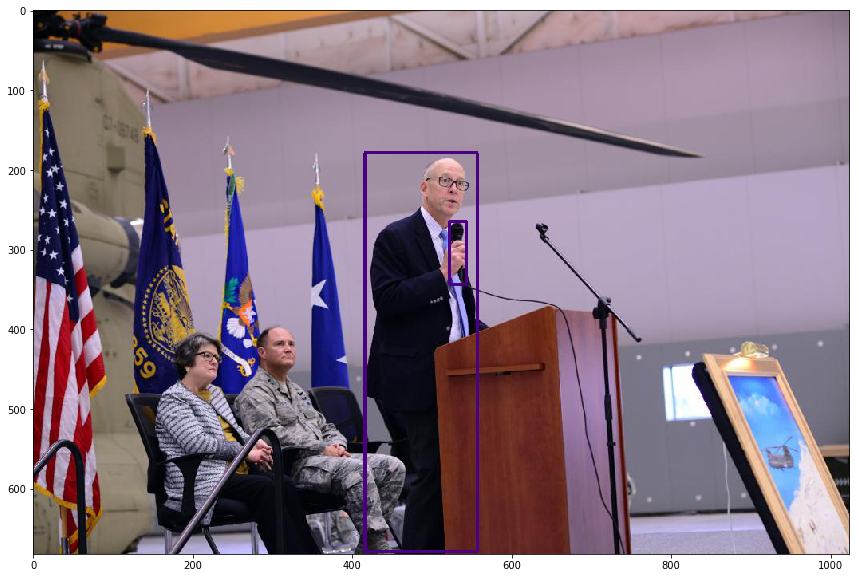

In [256]:
show_tuple_relation(df_test_pos, 3100, test_mode=True)

In [116]:
df_trip = pd.read_csv(os.path.join(DATA_DIR, 'challenge-2019-relationship-triplets.csv'))
df_trip.head()

,LabelName1,LabelName2,RelationshipLabel
0,/m/01599,/m/04bcr3,on
1,/m/05r655,/m/0h8my_4,holds
2,/m/05r655,/m/03k3r,on
3,/m/04yx4,/m/0l14j_,holds
4,/m/05r655,/m/080hkjn,wears


In [117]:
df_trip.loc[df_trip.RelationshipLabel=='is'].shape

(42, 3)

In [118]:
df_trip.shape

(329, 3)